In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gzip
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from itertools import compress
import math
from imblearn.over_sampling import RandomOverSampler

In [ ]:
main_path = '/content/drive/MyDrive/NUS/Y4S1/DSA4266/DSA4266 chromoteers/' #reb's path

If the cells before the checkpoints have been run once before, the next time around, you may start running from the checkpoint.

# Checkpoint 0: Processing Training Data

## Converting JSON to CSV (run once only)


In [ ]:
with gzip.open(main_path + 'dataset0.json.gz', 'r') as file_in:
    data = file_in.read().decode("utf-8") #change byte to string

# Load data into a DataFrame

#split data line by line
data_lines = data.split('\n')[:-1] #remove last empty string, 121838 lines

frames = []
for line in data_lines:

  # Parse the string as a JSON object
  data_dict = json.loads(line)

  # Convert the nested dictionary into a list of lists
  data_list = []
  for gene, values in data_dict.items():
      for pos, subvalues in values.items():
          for base, sublist in subvalues.items():
              data_list.append([gene, pos, base, sublist])

  # Create a DataFrame from the list of lists
  df = pd.DataFrame(data_list,columns=['transcript_id', 'transcript_position','nucleotides', 'reads']) #each row
  frames.append(df)

data_df = pd.concat(frames,ignore_index=True)

In [ ]:
#Save as a csv for future reference
data_df.to_csv(main_path +'dataset0.csv.gz', index=False, compression='gzip') #dont save index col

"\ncompressed_df = data_df.to_csv(None, compression='gzip', index=False) #dont save index col\nwith open('data_df.csv.gz', 'wb') as f:\n    f.write(compressed_df)\n"

# Checkpoint 1: Loading CSVs (for easy access to the csvs)

In [ ]:
#For the sake of being faster, load the zipped csv instead of creating the whole dataframe.

# Load the data (dataset0.csv.gz)
data_file = 'dataset0.csv.gz'

# Load data into a DataFrame
with gzip.open(main_path + data_file, 'rb') as file_in:
  data_df = pd.read_csv(file_in)

In [ ]:
# Load the m6A labels (data.info)
labels_file = 'data.info'

# Load labels into a DataFrame
labels_df = pd.read_csv(main_path + labels_file)

In [ ]:
labels_df.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [ ]:
data_df.head()

,transcript_id,transcript_position,nucleotides,reads
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0...."
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0..."


In [ ]:
# check size
print(labels_df.size)
print(data_df.size)

487352
487352


In [ ]:
# check for null values
labels_df[labels_df.isnull().any(axis=1)]

,gene_id,transcript_id,transcript_position,label


In [ ]:
data_df[data_df.isnull().any(axis=1)]

,transcript_id,transcript_position,nucleotides,reads


## EDA: Imbalanced dataset

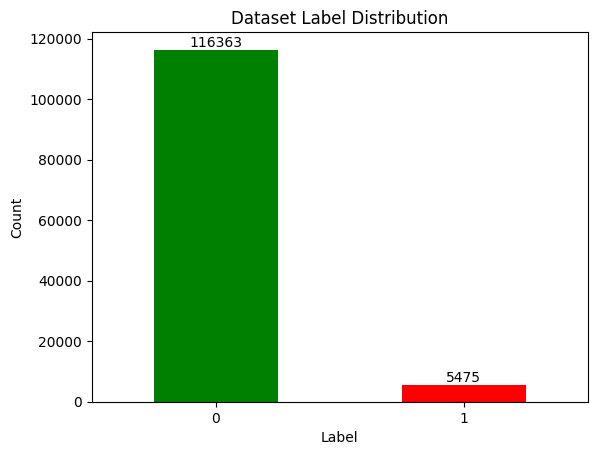

In [ ]:
#Check if the data is balanced
value_counts = labels_df['label'].value_counts()
ax = value_counts.plot(kind='bar', color = ['green','red'])
# Add labels to the bars
for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Dataset Label Distribution')
plt.xticks(rotation=0)
plt.show() #5475 modifications in data set

## Combining reads (run once only)

In [ ]:
#(1) length of the direct RNA-Seq signal of the 5-mer nucleotides (dwelling time),
#(2) standard deviation of the direct RNA-Seq signal, and
#(3) mean of the direct RNA-Seq signal.

# define a function to split the list into columns
def split_list(row):
    return pd.Series(row['combined_reads'])

def agg_func(input_reads):
    #print(input_df)
    #input_reads = json.loads(input_reads)
    agg_reads = []
    for var in range(9): #each var each position
        val_list = []
        for read in input_reads:
            val_list.append(read[var])
        agg_reads.append(np.mean(val_list))
        agg_reads.append(min(val_list))
        agg_reads.append(max(val_list))
        agg_reads.append(np.std(val_list))
    return agg_reads

data_df['combined_reads'] = data_df['reads'].apply(agg_func)


# apply the function to the DataFrame
new_data_df = data_df.apply(split_list, axis=1).rename(columns=lambda x: f"combined_reads_p{((x//4)//3)-1}_t{((x//4)%3)+1}_v{(x%4)+1}")

# merge the new DataFrame with the original DataFrame
result_data_df = pd.concat([data_df, new_data_df], axis=1).drop('combined_reads', axis=1)


p is position, p-1, p0, p1
t is type, t1 = dwell, t2 = sd, t3 = mean
v is variable, v1 = mean, v2 = min, v3 = max, v4 =sd

In [ ]:
#Save as a csv for future reference
result_data_df.to_csv(main_path +'result_dataset0.csv.gz', index=False, compression='gzip') #dont save index col

<Axes: >

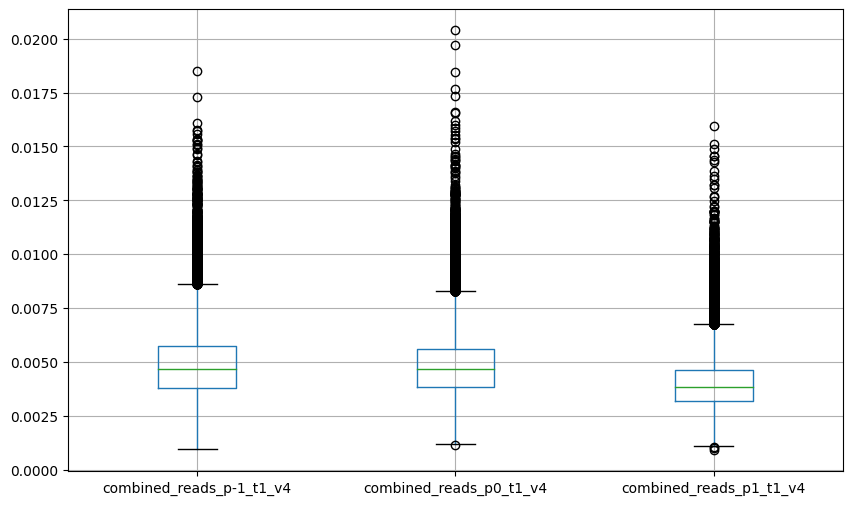

In [ ]:
allp_dwell_sd = ["combined_reads_p-1_t1_v4","combined_reads_p0_t1_v4","combined_reads_p1_t1_v4"]
result_data_df.boxplot(column=allp_dwell_sd,figsize=(10,6))

# Checkpoint 2: Loading combined reads (for easy access)

In [ ]:
#Loading full dataset (train.csv.gz)
result_data_file = 'result_dataset0.csv.gz'

# Load data into a DataFrame
with gzip.open(main_path + result_data_file, 'rb') as file_in:
  result_data_df = pd.read_csv(file_in)

In [ ]:
# Load the m6A labels (data.info)
labels_file = 'data.info'

# Load labels into a DataFrame
labels_df = pd.read_csv(main_path + labels_file)

##  Merging with labels (run once only)

In [ ]:
train_df = pd.merge(labels_df, result_data_df, on=["transcript_id","transcript_position"], how="outer")

In [ ]:
result_df_check = pd.merge(labels_df, result_data_df, on=["transcript_id","transcript_position"], how="inner")

In [ ]:
train_df.size

5117196

In [ ]:
result_df_check.size #check that all are merged successfully

5117196

In [ ]:
#save as train.csv.gz
train_path = main_path +'train.csv.gz'
train_df.to_csv(train_path, index=False, compression='gzip')

# Checkpoint 3: Loading train file (for easy access)

In [ ]:
#Loading full dataset (train.csv.gz)
train_path = main_path +'train.csv.gz'

# Load data into a DataFrame
with gzip.open(train_path, 'rb') as file_in:
  train_df = pd.read_csv(file_in)